# Маркетинговый анализ Яндекс Афишы

Отделу маркетинговой аналитики Яндекс.Афиши необходимо помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Необходимо изучить:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.

Выручка измеряется в условных единицах — у.е.

## Загрузка данных и подготовка их к анализу

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [ ]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [ ]:
visits.columns = ['device', 'end_ts', 'source_id','start_ts', 'uid']

In [ ]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [ ]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [ ]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<div class="alert alert-block alert-info">
<b>Проверка таблиц на дубликаты</b> <a class="tocSkip"></a>
    
Проверила все таблички на дубликаты - дубликаты отсутствуют.
</div>

In [ ]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null object
source_id    359400 non-null int64
start_ts     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [ ]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [ ]:
visits.duplicated().sum()

0

In [ ]:
orders.duplicated().sum()

0

In [ ]:
costs.duplicated().sum()

0

In [ ]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [ ]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

In [ ]:
costs['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10])

In [ ]:
visits['source_id'].unique()

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

### Вывод

- Названия столбцов приведены к нижнему регистру, пробелы заменены на нижние подчеркивания
- Пропуски в данных не обнаружены
- Дубликаты в данных не обнаружены
- Столбцы, содержащие в себе дату, приведены к типу данных datetime
- Cтолбец device проверен на уникальные значения
- Cтолбец source_id проверен на уникальные значения

## Расчет метрик

### Продуктовые метрики

#### Рассчитайте DAU, WAU и MAU. Вычислите средние значения этих метрик за весь период. Отобразите изменения метрик во времени на графиках

In [ ]:
visits['year']  = visits['start_ts'].astype('datetime64[Y]')
visits['month'] = visits['start_ts'].astype('datetime64[M]')
visits['week']  = visits['start_ts'].astype('datetime64[W]')
visits['date'] = visits['start_ts'].astype('datetime64[D]')
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27


In [ ]:
dau = visits.groupby('date').agg({'uid': 'nunique'})
wau = visits.groupby(['week']).agg({'uid': 'nunique'})
mau = visits.groupby(['month']).agg({'uid': 'nunique'})
sticky_mau = (dau.mean()/mau.mean())*100
sticky_wau = (dau.mean()/wau.mean())*100
print('Количество уникальных пользователей в день: {}'.format(int(dau.mean())))
print('Количество уникальныйх пользователей в неделю: {}'.format(int(wau.mean())))
print('Количество уникальных пользователей в месяц {}'.format(int(mau.mean())))
print('Недельная вовлеченность аудитории: {:.2f}%'.format(sticky_wau[0]))
print('Месячная вовлеченность аудитории: {:.2f}%'.format(sticky_mau[0]))

Количество уникальных пользователей в день: 907
Количество уникальныйх пользователей в неделю: 5724
Количество уникальных пользователей в месяц 23228
Недельная вовлеченность аудитории: 15.86%
Месячная вовлеченность аудитории: 3.91%


Количество уникальных пользователей достаточное, однако вовлеченность аудитории не очень высока, видимо пользователи не очень часто обращатся к сервису.

Text(0, 0.5, 'Количество пользователей')

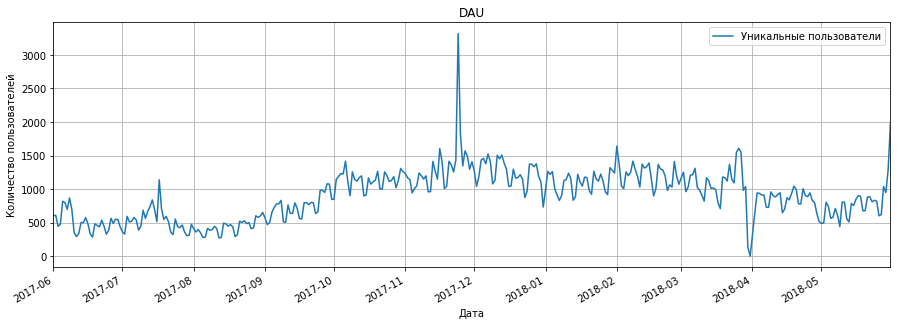

In [ ]:
dau.plot(grid = True, figsize = (15,5))
plt.title('DAU')
plt.legend(['Уникальные пользователи'])
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')

Text(0, 0.5, 'Количество пользователей')

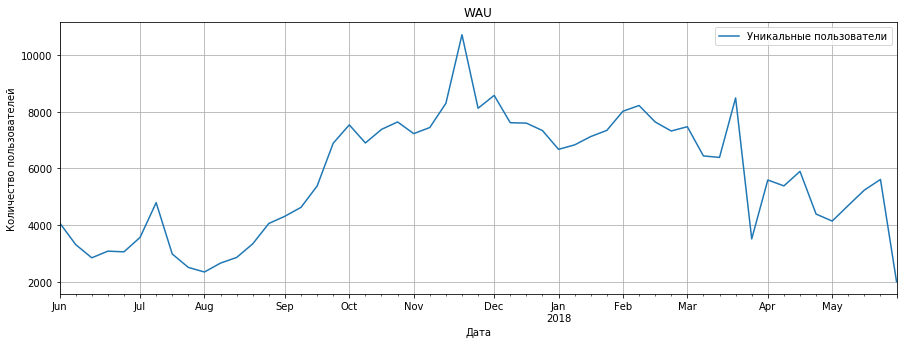

In [ ]:
wau.plot(grid = True, figsize = (15,5))
plt.title('WAU')
plt.legend(['Уникальные пользователи'])
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')

Text(0, 0.5, 'Количество пользователей')

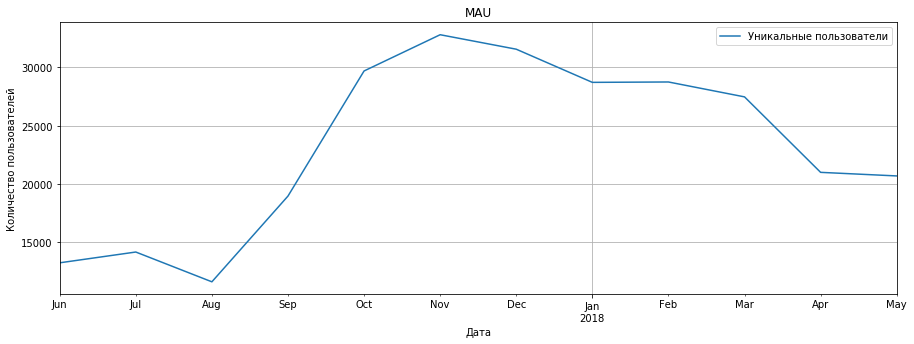

In [ ]:
mau.plot(grid = True, figsize = (15,5))
plt.title('MAU')
plt.legend(['Уникальные пользователи'])
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')

Построив и проанализиров графики изменения метрик DAU, WAU, MAU во времени, наблюдаем, что максимум количества уникальных пользователей приходится на декабрь, на период перед новогодними праздниками, минимум же на апрель - здесь влияние могут оказывать предстоящие майские праздники, а также количество уникальных пользователей снижается летом - еще один минимум в августе.

#### Определите, сколько раз за день пользователи в среднем заходят на сайт. Постройте график, отражающий изменения метрики во времени

In [ ]:
daily_sessions = visits.groupby('date').agg({'uid':['count', 'nunique']})
daily_sessions.columns = ['uid_count','uid_n_unique_count']
daily_sessions['sess_per_user'] = daily_sessions['uid_count']/daily_sessions['uid_n_unique_count']
daily_sessions['sess_per_user'].mean()

1.082169644003972

В среднем пользователи за день заходят на сайт один раз.

Text(0, 0.5, 'Количество пользователей')

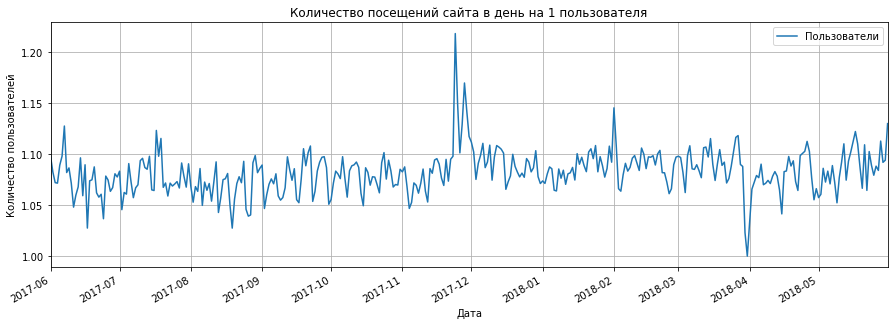

In [ ]:
daily_sessions['sess_per_user'].plot(grid = True, figsize = (15,5))
plt.title('Количество посещений сайта в день на 1 пользователя')
plt.legend(['Пользователи'])
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')

Наибольшее количество заходов на сайт за период наблюдается в декабре, еще один пик мы наблюдаем в конце февраля (возможно влияние оказывает праздник 8 марта), наименьшее количество заходов в апреле.

#### Исследуйте, сколько времени пользователи проводят на сайте. Узнайте продолжительность типичной пользовательской сессии за весь период. Чтобы выбрать подходящую среднюю меру, постройте график распределения. Изменение продолжительности сессий во времени изучать необязательно

(0, 10000)

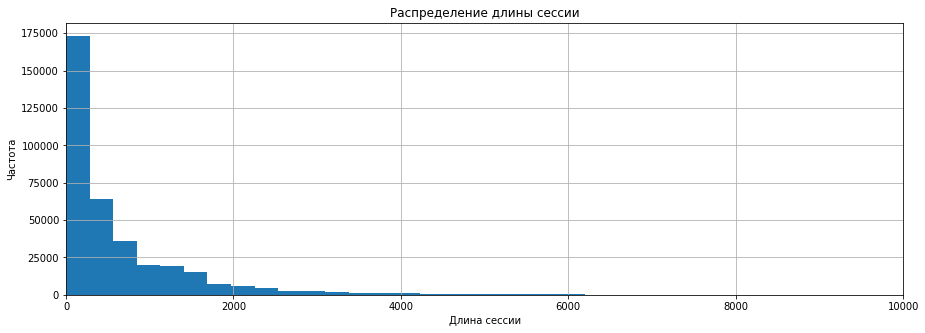

In [ ]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
plt.figure(figsize = (15,5))
visits['session_duration_sec'].hist(bins=300).set(title = 'Распределение длины сессии', xlabel = 'Длина сессии', ylabel = 'Частота' )
plt.xlim(0,10000)

Проанализиров график, видим, что коротких пользовательских сессий гораздо больше, чем продолжительных. Найдем самое частое значение длины сессии пользователя на сайте.

In [ ]:
visits['session_duration_sec'].mode()

0    60
dtype: int64

Самая частая продолжительность сессии пользователя на сайте равна 1 минуте.

<div class="alert alert-block alert-info">
<b>Сравним моду с медианой и средним</b><a class="tocSkip"></a>
    
Выведем также среднее значение продолжительности сессии на сайте - mean() и посмотрим медиану.
</div>

In [ ]:
(visits['session_duration_sec'].mean())/60

10.725108143201632

Средняя продолжительность сессии пользователя на сайте равна 10 минутам. Это уже больше похоже на время, достаточное для пользователя для выбора необходимого ему продукта.

In [ ]:
(visits['session_duration_sec'].median())/60

5.0

Медианная продолжительность сессии пользователя на сайте равна 5 минутам.

Средняя продолжительность сессии пользователя на сайте равна 10 минутам, но чаще всего пользователи проводят на сайте не больше одной минуты.

#### Рассчитайте Retention Rate, применяя когортный анализ. Покажите изменения метрики во времени на графике. Найдите средний Retention Rate на второй месяц «жизни» когорт

Подчитаем Retention Rate или коэффициент удержания пользователей сервиса. Для этого, разделим пользователей на когорты.

Находим для каждого пользователя минимальный визит или номер дальнейшей когорты.

In [ ]:
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_session_date'
first_activity_date.head()

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: first_session_date, dtype: datetime64[ns]

Добавляем информацию о первом визите к данным о визитах.

In [ ]:
visits = visits.join(first_activity_date, on='uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date,session_duration_sec,first_session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27,0,2017-12-27 14:06:00


In [ ]:
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['first_session_month'] = visits['first_session_date'].astype('datetime64[M]')

Считаем сколько месяцев прошло между каждой сессией и первой сессией.

In [ ]:
visits['cohort_lifetime'] = visits['session_month'] - visits['first_session_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date,session_duration_sec,first_session_date,session_month,first_session_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09 20:05:00,2018-05-01,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27,0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0


Сгруппируем данные по когорте и  ее lifetime, также посчитаем для каждой когорты на определенный месяц количество активных пользователей. 

In [ ]:
cohorts = visits.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts.head(15)

,first_session_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
5,2017-06-01,5,947
6,2017-06-01,6,809
7,2017-06-01,7,766
8,2017-06-01,8,694
9,2017-06-01,9,674


Найдем исходное количество пользователей в когорте.

In [ ]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

In [ ]:
cohorts = cohorts.merge(initial_users_count,on='first_session_month')
cohorts

,first_session_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259
...,...,...,...,...
73,2018-03-01,1,861,20589
74,2018-03-01,2,557,20589
75,2018-04-01,0,15709,15709
76,2018-04-01,1,760,15709


Рассчитаем Retention Rate.

In [ ]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 

retention_pivot = cohorts.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)

retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


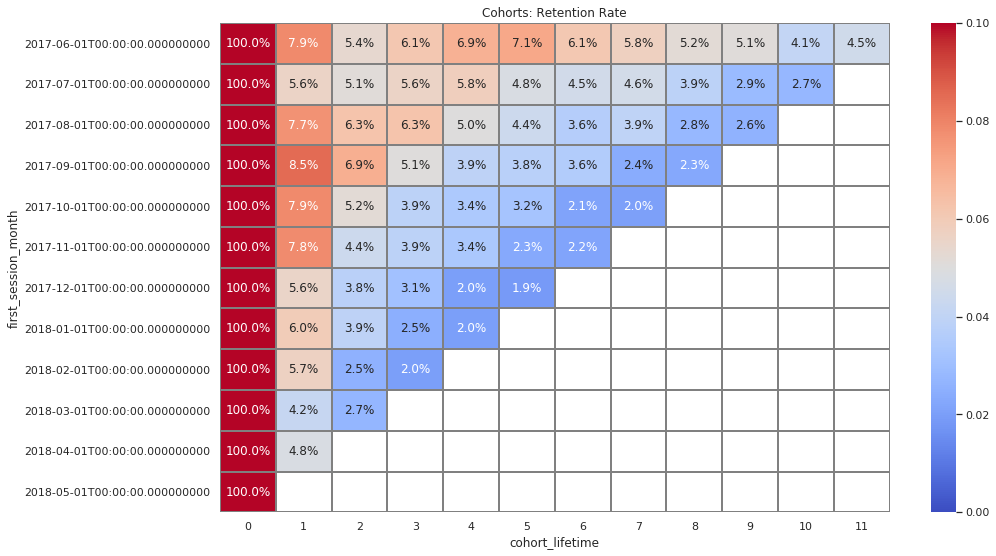

In [ ]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Cohorts: Retention Rate')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap = 'coolwarm', vmin = 0, vmax = 0.1)

Retention Rate активно убывает по когортам с течением времени. На первый месяц жизни когорты самый высокий RR у когорты 2017-09 - 8,5%, но в дальнейшем он начинает падать. Самая активная и постоянная на фоне остальных -первая когорта 2017-06.  Хорошие показатели RR на первые месяцы жизни также у когорт 2017-08, 2017-10, 2017-11, но с течением времени он также убывает.

Найти средний Retention Rate на второй месяц «жизни» когорт

In [ ]:
round((retention_pivot[2].mean())*100,2)

4.63

На второй месяц жизни когорт Retention Rate составляет 4.63%.

### Метрики электронной коммерции

#### Исследуйте, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. Изучать изменение этой метрики во времени необязательно

In [ ]:
first_visit = visits.groupby(['uid'])['start_ts'].min()
orders = orders.join(first_visit, on='uid')
orders.head()

,buy_ts,revenue,uid,start_ts
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00


In [ ]:
orders['days_to_first_purchase'] = orders['buy_ts'] - orders['start_ts']
orders.head()

,buy_ts,revenue,uid,start_ts,days_to_first_purchase
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,00:01:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,00:11:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,00:02:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,00:15:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,00:27:00


In [ ]:
orders['days_to_first_purchase'] = orders['days_to_first_purchase'] / np.timedelta64(1, 'D')
orders['days_to_first_purchase'] = orders['days_to_first_purchase'].round().astype('int')
orders.head()

,buy_ts,revenue,uid,start_ts,days_to_first_purchase
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,0


In [ ]:
orders['days_to_first_purchase'].describe()

count    50415.000000
mean        37.025072
std         70.610417
min          0.000000
25%          0.000000
50%          0.000000
75%         38.000000
max        364.000000
Name: days_to_first_purchase, dtype: float64

(0, 100)

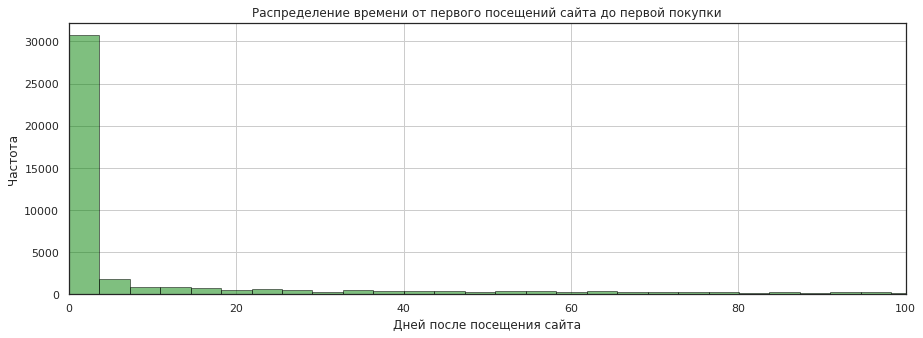

In [ ]:
plt.figure(figsize=(15, 5))
orders['days_to_first_purchase'].plot(
                kind='hist', 
                bins= 100, 
                alpha=0.5, 
                ec='black',
                color='green',
                grid = True
                ). set(title ='Распределение времени от первого посещений сайта до первой покупки', xlabel = 'Дней после посещения сайта', ylabel ='Частота')
plt.xlim(0,100)

In [ ]:
orders['days_to_first_purchase'].mode()

0    0
dtype: int64

Самое частое время покупки -  0 дней. Пользователи не растягивают время до покупки.

<div class="alert alert-block alert-info">
<b>Сравним моду с медианой и средним</b><a class="tocSkip"></a>
    
Выведем также среднее значение времени от первого посещения сайта до первой покупки - mean() и посмотрим медиану.
</div>

In [ ]:
orders['days_to_first_purchase'].mean()

37.02507190320341

Среднее значение времени от первого посещения сайта до первой покупки - 37 дней, чуть больше месяца - достаточно долго, особенно по сравнению с 0 дней.

In [ ]:
orders['days_to_first_purchase'].median()

0.0

Медианное время тоже 0 дней.

Чаще всего пользователи долго не думают над покупкой. Решение о покупке занимает у них 0 дней, однако среднее время покупки - 37 дней (достаточно долго для принятия решения о покупке билетов на какое-нибудь мероприятие)

#### Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. Изучать изменение этой метрики во времени необязательно

Находим для каждого пользователя минимальный месяц покупки или номер дальнейшей когорты.

In [ ]:
first_buy_date = orders.groupby(['uid'])['buy_ts'].min()
first_buy_date.name = 'first_buy_date'
orders = orders.join(first_buy_date, on='uid')
orders.head()

,buy_ts,revenue,uid,start_ts,days_to_first_purchase,first_buy_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,0,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,0,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,0,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,0,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,0,2017-06-01 07:58:00


In [ ]:
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_buy_month'] = orders['first_buy_date'].astype('datetime64[M]')

In [ ]:
orders['cohort_lifetime'] = orders['buy_month'] - orders['first_buy_month']
orders['cohort_lifetime'] = orders['cohort_lifetime'] / np.timedelta64(1, 'M')
orders['cohort_lifetime'] = orders['cohort_lifetime'].round().astype('int')
orders.head()

,buy_ts,revenue,uid,start_ts,days_to_first_purchase,first_buy_date,buy_month,first_buy_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,0,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,0,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,0,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,0,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,0,2017-06-01 07:58:00,2017-06-01,2017-06-01,0


In [ ]:
cohort_sizes = orders.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month','n_buyers']
cohort_sizes

,first_buy_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [ ]:
cohorts_1 = orders.groupby(['first_buy_month','cohort_lifetime']).agg({'uid':'count'}).reset_index()
cohorts_1.columns= ['first_buy_month', 'cohort_lifetime','n_orders' ]
cohorts_1.head(15)

,first_buy_month,cohort_lifetime,n_orders
0,2017-06-01,0,2354
1,2017-06-01,1,177
2,2017-06-01,2,174
3,2017-06-01,3,226
4,2017-06-01,4,292
5,2017-06-01,5,218
6,2017-06-01,6,276
7,2017-06-01,7,174
8,2017-06-01,8,212
9,2017-06-01,9,153


In [ ]:
cohorts_1 = cohorts_1.merge(cohort_sizes, on = 'first_buy_month')
cohorts_1

,first_buy_month,cohort_lifetime,n_orders,n_buyers
0,2017-06-01,0,2354,2023
1,2017-06-01,1,177,2023
2,2017-06-01,2,174,2023
3,2017-06-01,3,226,2023
4,2017-06-01,4,292,2023
...,...,...,...,...
74,2018-03-01,2,176,3533
75,2018-04-01,0,2495,2276
76,2018-04-01,1,195,2276
77,2018-05-01,0,3249,2988


In [ ]:
cohorts_1['buys_per_user'] = cohorts_1['n_orders']/cohorts_1['n_buyers'] 
cohorts_1

,first_buy_month,cohort_lifetime,n_orders,n_buyers,buys_per_user
0,2017-06-01,0,2354,2023,1.163618
1,2017-06-01,1,177,2023,0.087494
2,2017-06-01,2,174,2023,0.086011
3,2017-06-01,3,226,2023,0.111715
4,2017-06-01,4,292,2023,0.144340
...,...,...,...,...,...
74,2018-03-01,2,176,3533,0.049816
75,2018-04-01,0,2495,2276,1.096221
76,2018-04-01,1,195,2276,0.085677
77,2018-05-01,0,3249,2988,1.087349


In [ ]:
orders_pivot = cohorts_1.pivot_table(
    index='first_buy_month',
    columns='cohort_lifetime',
    values='buys_per_user',
    aggfunc='sum',
).cumsum(axis = 1)
orders_pivot.round(2).fillna(' ')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.92,2.03,2.1,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.5,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12-01,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.21,1.22,,,,,,,,


In [ ]:
round(orders_pivot[5].mean(),2)

1.43

Проанализировав таблицу среднего количества покупок на одного пользователя видим, что показатель в 2 покупки достигается только у первой когорты 2017-06. По всем когортам число среднего количества покупок с течением времени увеличивается, но ненамного. Таким образом, делаем вывод, что совершают повторные покупки, но не слишком часто.

#### Рассчитайте средний чек, применяя группировку по времени совершения покупки. Когортный анализ не подходит — он может исказить расчёты. Постройте график, отражающий изменения метрики во времени

In [ ]:
orders_grouped_by_buy_month = orders.groupby(['buy_month']).agg({'revenue': 'sum', 'uid': 'count'})
orders_grouped_by_buy_month['revenue_per_order'] = orders_grouped_by_buy_month['revenue'] / orders_grouped_by_buy_month['uid']
orders_grouped_by_buy_month

,revenue,uid,revenue_per_order
buy_month,,,
2017-06-01,9557.49,2354,4.060106
2017-07-01,12539.47,2363,5.306589
2017-08-01,8758.78,1807,4.847139
2017-09-01,18345.51,3387,5.416448
2017-10-01,27987.70,5679,4.928280
2017-11-01,27069.93,5659,4.783518
2017-12-01,36388.60,6218,5.852139
2018-01-01,19417.13,4721,4.112927
2018-02-01,25560.54,5281,4.840095


In [ ]:
round(orders_grouped_by_buy_month['revenue_per_order'].mean(),2)

4.84

Text(0, 0.5, 'Выручка, уе')

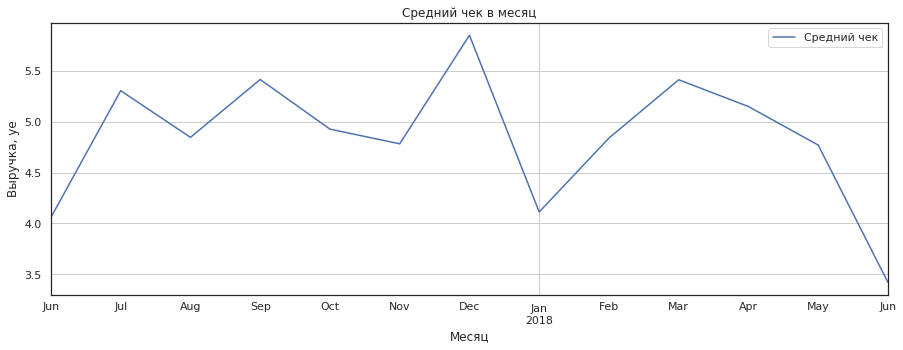

In [ ]:
orders_grouped_by_buy_month['revenue_per_order'].plot(grid = True, figsize = (15,5))
plt.title('Средний чек в месяц')
plt.legend(['Средний чек'])
plt.xlabel('Месяц')
plt.ylabel('Выручка, уе')

Средний чек покупки приближается к значени в 5 у.е. Наибольшее значение средний чек принимает в конце года, перед новогодними праздниками, потом резко его значение падает в январе, - наименьшее летом, в июне, июле.

#### Выясните, как меняется LTV на покупателя по когортам. Помните, что LTV — накопительная метрика. Рассчитайте средний LTV по когортам за 6 месяцев; в расчёт включайте когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%. Отразите изменения метрики во времени на графике

In [ ]:
cohorts_2 = orders.groupby(['first_buy_month', 'buy_month']).agg({'revenue': 'sum'}).reset_index()
cohorts_2.head()

,first_buy_month,buy_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [ ]:
cohorts_2 = cohorts_2.merge(cohort_sizes, on = 'first_buy_month')
cohorts_2 

,first_buy_month,buy_month,revenue,n_buyers
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,2023
2,2017-06-01,2017-08-01,885.34,2023
3,2017-06-01,2017-09-01,1931.30,2023
4,2017-06-01,2017-10-01,2068.58,2023
...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3533
75,2018-04-01,2018-04-01,10600.69,2276
76,2018-04-01,2018-05-01,1209.92,2276
77,2018-05-01,2018-05-01,13925.76,2988


In [ ]:
cohorts_2['revenue_per_buyer'] = cohorts_2['revenue']/cohorts_2['n_buyers']
cohorts_2

,first_buy_month,buy_month,revenue,n_buyers,revenue_per_buyer
0,2017-06-01,2017-06-01,9557.49,2023,4.724414
1,2017-06-01,2017-07-01,981.82,2023,0.485329
2,2017-06-01,2017-08-01,885.34,2023,0.437637
3,2017-06-01,2017-09-01,1931.30,2023,0.954671
4,2017-06-01,2017-10-01,2068.58,2023,1.022531
...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3533,0.315559
75,2018-04-01,2018-04-01,10600.69,2276,4.657597
76,2018-04-01,2018-05-01,1209.92,2276,0.531599
77,2018-05-01,2018-05-01,13925.76,2988,4.660562


In [ ]:
margin_rate = 1
cohorts_2['age'] = (cohorts_2['buy_month'] - cohorts_2['first_buy_month']) / np.timedelta64(1, 'M')
cohorts_2['age'] = cohorts_2['age'].round().astype('int')
cohorts_2['ltv'] = cohorts_2['revenue_per_buyer'] * margin_rate
cohorts_2

,first_buy_month,buy_month,revenue,n_buyers,revenue_per_buyer,age,ltv
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0,4.724414
1,2017-06-01,2017-07-01,981.82,2023,0.485329,1,0.485329
2,2017-06-01,2017-08-01,885.34,2023,0.437637,2,0.437637
3,2017-06-01,2017-09-01,1931.30,2023,0.954671,3,0.954671
4,2017-06-01,2017-10-01,2068.58,2023,1.022531,4,1.022531
...,...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3533,0.315559,2,0.315559
75,2018-04-01,2018-04-01,10600.69,2276,4.657597,0,4.657597
76,2018-04-01,2018-05-01,1209.92,2276,0.531599,1,0.531599
77,2018-05-01,2018-05-01,13925.76,2988,4.660562,0,4.660562


In [ ]:
ltv_pivot = cohorts_2.pivot_table(index='first_buy_month',columns='age',values='ltv',aggfunc='sum').cumsum(axis=1)
ltv_pivot.round(2).fillna(' ')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


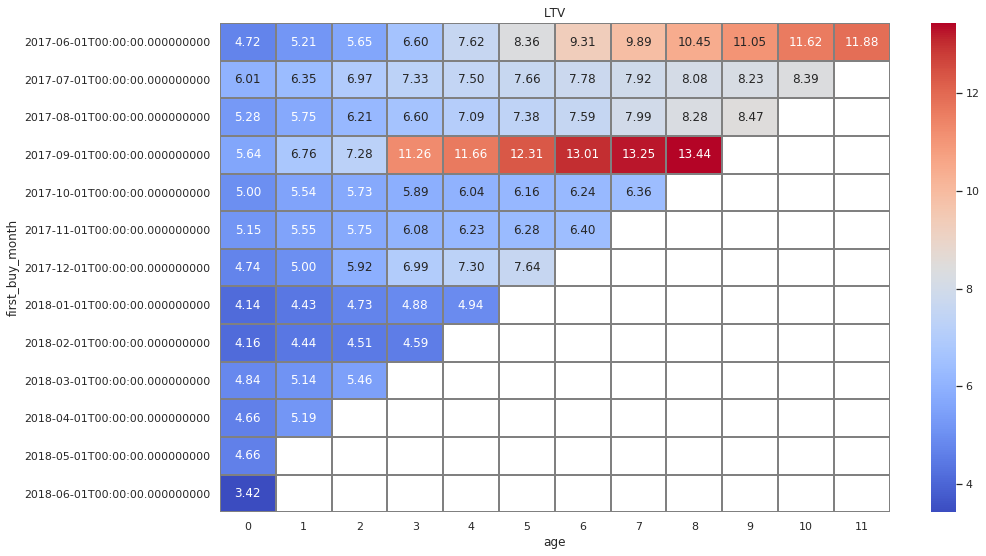

In [ ]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV')
sns.heatmap(ltv_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap = 'coolwarm');

Самые лучшие результаты показывают когорты 2017-06 и 2017-09, при этом LTV сентябрьской когорты растет быстрее.

In [ ]:
round(ltv_pivot[5].mean(),2)

7.97

Средний LTV за 6 месяцев равен почти 8 у.е.

### Маркетинговые метрики

#### Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам. Визуализируйте изменения метрик во времени

Добавим месяц расходов.

In [ ]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


In [ ]:
costs['costs'].sum()

329131.62

За все время на маркетинговые расходы было потрачено 329131.62 у.е.

In [ ]:
costs_grouped_by_source = costs.groupby('source_id')['costs'].sum()
costs_grouped_by_source

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Text(0, 0.5, 'Траты в %')

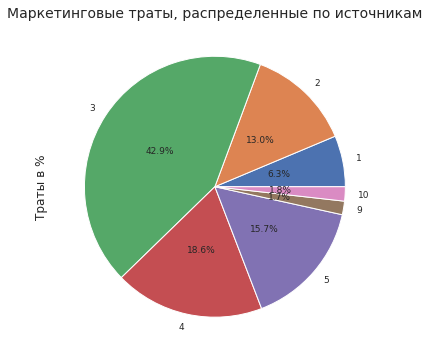

In [ ]:
pie, ax = plt.subplots(figsize=[10,6])
labels = costs_grouped_by_source.keys()
plt.pie(x=costs_grouped_by_source, autopct="%.1f%%", pctdistance=0.5, labels=labels, textprops={'fontsize': 9})
plt.title("Маркетинговые траты, распределенные по источникам", fontsize=14)
plt.ylabel('Траты в %')

- Наибольшее число маркетинговых трат 42.9% приходится на 3 источник - 141321.63 у.е.
- Наименьшее число маркетинговых трат приходится на источники 1, 9, 10 - 6.3% (20833.27 у.е.) , 1.7% (5517.49 у.е.), 1.8% (5822.49 у.е.) соответственно.

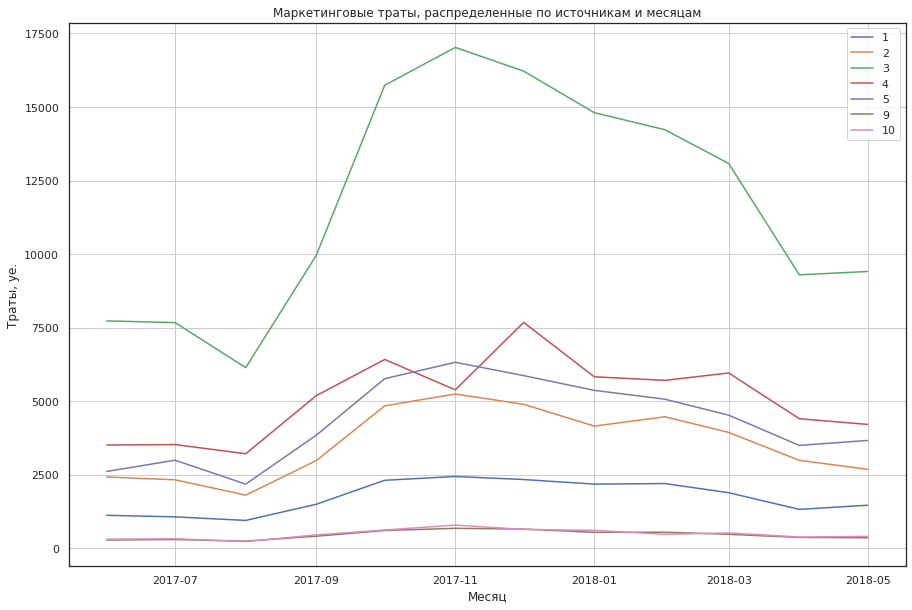

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Маркетинговые траты, распределенные по источникам и месяцам')
plt.xlabel('Месяц')
plt.ylabel('Траты, уе.')
plt.grid()

for p in costs['source_id'].unique():
    sns.lineplot(data = costs[(costs['source_id'] == p)].groupby('month')['costs'].sum(), label=p)
    plt.legend()

In [ ]:
costs_grouped_by_month = costs.groupby('month')['costs'].sum()
costs_grouped_by_month

month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

Text(0, 0.5, 'Траты, уе.')

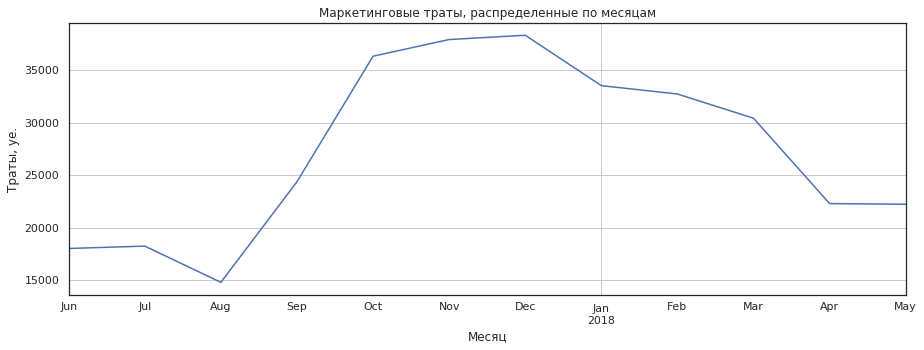

In [ ]:
costs_grouped_by_month.plot(grid = True, figsize = (15,5))
plt.title('Маркетинговые траты, распределенные по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Траты, уе.')

Наибольшие маркетинговые траты приходятся на период с октября по декабрь, наименьшие маркетинговые траты на летний период, минимум - в августе.

#### Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика. Отразите изменения метрик на графиках

In [ ]:
round(costs['costs'].sum()/orders['uid'].nunique(), 2)

9.01

Cредний CAC или стоимость привлечения клиента равен 9.01 у.е.

In [ ]:
costs_grouped_by_month_copy = costs_grouped_by_month.reset_index()
costs_grouped_by_month_copy.columns = ['first_buy_month','costs']
costs_grouped_by_month_copy

,first_buy_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [ ]:
cohorts_3 = cohorts_2
cohorts_3 = cohorts_3.merge(costs_grouped_by_month_copy,on='first_buy_month')
cohorts_3

,first_buy_month,buy_month,revenue,n_buyers,revenue_per_buyer,age,ltv,costs
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0,4.724414,18015.00
1,2017-06-01,2017-07-01,981.82,2023,0.485329,1,0.485329,18015.00
2,2017-06-01,2017-08-01,885.34,2023,0.437637,2,0.437637,18015.00
3,2017-06-01,2017-09-01,1931.30,2023,0.954671,3,0.954671,18015.00
4,2017-06-01,2017-10-01,2068.58,2023,1.022531,4,1.022531,18015.00
...,...,...,...,...,...,...,...,...
73,2018-03-01,2018-04-01,1063.05,3533,0.300892,1,0.300892,30415.27
74,2018-03-01,2018-05-01,1114.87,3533,0.315559,2,0.315559,30415.27
75,2018-04-01,2018-04-01,10600.69,2276,4.657597,0,4.657597,22289.38
76,2018-04-01,2018-05-01,1209.92,2276,0.531599,1,0.531599,22289.38


In [ ]:
cohorts_3['cac'] = cohorts_3['costs'] / cohorts_3['n_buyers']
cohorts_3

,first_buy_month,buy_month,revenue,n_buyers,revenue_per_buyer,age,ltv,costs,cac
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0,4.724414,18015.00,8.905091
1,2017-06-01,2017-07-01,981.82,2023,0.485329,1,0.485329,18015.00,8.905091
2,2017-06-01,2017-08-01,885.34,2023,0.437637,2,0.437637,18015.00,8.905091
3,2017-06-01,2017-09-01,1931.30,2023,0.954671,3,0.954671,18015.00,8.905091
4,2017-06-01,2017-10-01,2068.58,2023,1.022531,4,1.022531,18015.00,8.905091
...,...,...,...,...,...,...,...,...,...
73,2018-03-01,2018-04-01,1063.05,3533,0.300892,1,0.300892,30415.27,8.608907
74,2018-03-01,2018-05-01,1114.87,3533,0.315559,2,0.315559,30415.27,8.608907
75,2018-04-01,2018-04-01,10600.69,2276,4.657597,0,4.657597,22289.38,9.793225
76,2018-04-01,2018-05-01,1209.92,2276,0.531599,1,0.531599,22289.38,9.793225


In [ ]:
cac_grouped_by_month = cohorts_3.groupby('first_buy_month')['cac'].mean()
cac_grouped_by_month

first_buy_month
2017-06-01     8.905091
2017-07-01     9.485486
2017-08-01    10.796015
2017-09-01     9.441654
2017-10-01     8.369327
2017-11-01     9.288870
2017-12-01     8.741809
2018-01-01     9.937302
2018-02-01     8.962758
2018-03-01     8.608907
2018-04-01     9.793225
2018-05-01     7.437841
Name: cac, dtype: float64

Text(0, 0.5, 'Траты, уе.')

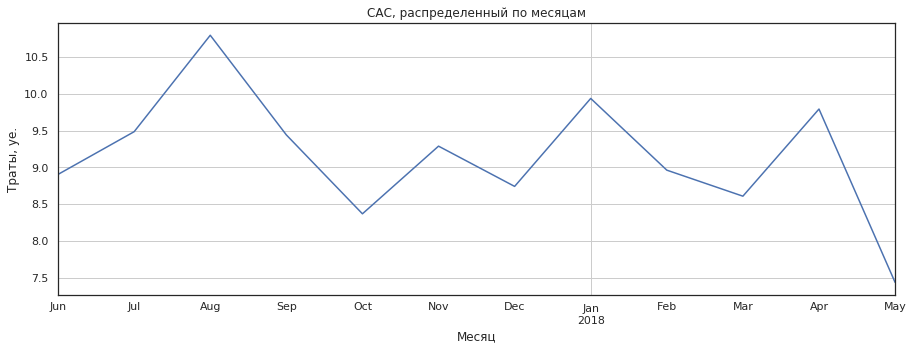

In [ ]:
cac_grouped_by_month.plot(grid = True, figsize = (15,5))
plt.title('СAC, распределенный по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Траты, уе.')

Наибольшие значения CAC принимает в августе, январе и апреле, наименьшие в мае, октябре и декабре.

Для каждого пользователя определим первый привлекший его источник.

In [ ]:
first_source_per_user = visits.sort_values(by = 'start_ts').groupby('uid').agg({'source_id': 'first'}).reset_index()
first_source_per_user.columns = ['uid','first_source_id']
first_source_per_user

,uid,first_source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5
...,...,...
228164,18446403737806311543,5
228165,18446424184725333426,4
228166,18446556406699109058,3
228167,18446621818809592527,4


Теперь нужно определить, кто из этих пользователей был покупателем, сгруппировать по источнику и посчитать их количество.

Скопируем таблицу orders и оставим в них только нужные для дальнейшего расчета столбцы.

In [ ]:
orders_copy = orders[['buy_ts','revenue','uid','buy_month','first_buy_month']]
orders_copy.head()

,buy_ts,revenue,uid,buy_month,first_buy_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


К таблице orders добавим столбец, содержащий в себе первый привлекший пользователя источник.

In [ ]:
orders_and_first_source = orders_copy.merge(first_source_per_user, on='uid')
orders_and_first_source

,buy_ts,revenue,uid,buy_month,first_buy_month,first_source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,3
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-01,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-01,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-01,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2018-05-01,3


In [ ]:
n_buyers_by_source = orders_and_first_source.groupby('first_source_id').agg({'uid': 'count'}).reset_index()
n_buyers_by_source = n_buyers_by_source[n_buyers_by_source['first_source_id'] != 7]
n_buyers_by_source

,first_source_id,uid
0,1,5223
1,2,6392
2,3,13289
3,4,12895
4,5,9406
6,9,1647
7,10,1562


In [ ]:
costs_grouped_by_source = costs_grouped_by_source.reset_index()

In [ ]:
cac__by_source = pd.merge(costs_grouped_by_source, n_buyers_by_source, left_on = 'source_id', right_on = 'first_source_id')
cac__by_source['cac_by_source'] = cac__by_source['costs'] / cac__by_source['uid']
cac__by_source

,source_id,costs,first_source_id,uid,cac_by_source
0,1,20833.27,1,5223,3.988756
1,2,42806.04,2,6392,6.696815
2,3,141321.63,3,13289,10.634482
3,4,61073.60,4,12895,4.736223
4,5,51757.10,5,9406,5.502562
5,9,5517.49,9,1647,3.350024
6,10,5822.49,10,1562,3.727586


- Наибольшие значение CAC принимает для источника 3 - 10.6 у.е.
- Наименьшие значения CAC для источников 1, 9, 10 = 3.9 у.е., 3.3 у.е., 3.7 у.е соответственно.

#### Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт. Обратите внимание, что клиенты, пришедшие из разных источников, могут иметь разный LTV. Постройте графики, отражающие изменения метрик во времени

Сгруппируем таблицу costs по источнику и месяцу.

In [ ]:
costs_grouped_by_source_month = costs.groupby(['source_id','month']).agg({'costs':'sum'}).reset_index()
costs_grouped_by_source_month

,source_id,month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75
...,...,...,...
79,10,2018-01-01,614.35
80,10,2018-02-01,480.88
81,10,2018-03-01,526.41
82,10,2018-04-01,388.25


Напишем функцию расчета ROMI по когортам в разрезе источника.

<div class="alert alert-block alert-info">
<b>Подсчет LTV</b> <a class="tocSkip"></a>
    
Добавила подсчет усредненного LTV  для каждого источника.
</div>

In [ ]:
def print_romi_for_source(source):
    #cрез таблицы costs_grouped_by_source_month по источнику
    costs_grouped_by_source_month_slice = costs_grouped_by_source_month[costs_grouped_by_source_month['source_id']==source]
    #cрез таблицы orders_and_first_source по источнику
    orders_and_first_source_slice = orders_and_first_source[orders_and_first_source['first_source_id']==source]
    #найдем количество покупателей для каждой когорты
    cohort_sizes_slice = orders_and_first_source_slice.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes_slice.columns = ['first_buy_month','n_buyers']
    #подсчитаем revenue
    cohorts_revenue_slice = (orders_and_first_source_slice.groupby(['first_buy_month','buy_month']).agg({'revenue':'sum'}).reset_index())
    cohorts_revenue_slice.columns = ['first_buy_month', 'buy_month', 'revenue']
    cohorts_revenue_slice = cohorts_revenue_slice.merge(cohort_sizes_slice, on = 'first_buy_month')
    cohorts_revenue_slice['revenue_per_buyer'] = cohorts_revenue_slice['revenue']/cohorts_revenue_slice['n_buyers']
    #соединим таблицу revenue с costs
    cohorts_revenue_slice = cohorts_revenue_slice.merge(costs_grouped_by_source_month_slice, left_on = 'first_buy_month',right_on = 'month')
    #рассчитаем возраст когорты, ltv, cac, romi
    margin_rate = 1
    cohorts_revenue_slice['age'] = (cohorts_revenue_slice['buy_month'] - cohorts_revenue_slice['first_buy_month']) / np.timedelta64(1, 'M')
    cohorts_revenue_slice['age'] = cohorts_revenue_slice['age'].round().astype('int')
    cohorts_revenue_slice['ltv'] = cohorts_revenue_slice['revenue_per_buyer'] * margin_rate
    cohorts_revenue_slice['cac'] = cohorts_revenue_slice['costs'] / cohorts_revenue_slice['n_buyers']
    cohorts_revenue_slice['romi']=cohorts_revenue_slice['ltv']/cohorts_revenue_slice['cac']
    #создадим таблицу LTV по когорте
    ltv_report = cohorts_revenue_slice.pivot_table(
        index='first_buy_month', columns='age', values='ltv', aggfunc='sum').cumsum(axis=1)
    #Посчитаем LTV для средней когорты
    print('Усредненный LTV для источника '+str(source)) 
    print(ltv_report.mean(axis=0).mean())
    print('---------------------------------------------------')
    #создадим таблицу romi по когорте
    romi_report = cohorts_revenue_slice.pivot_table(
        index='first_buy_month', columns='age', values='romi', aggfunc='sum').cumsum(axis=1)
    #Посчитаем ROMI для средней когорты
    print('Окупаемость ROMI по средней когорте для источника '+str(source)) 
    print(romi_report.mean(axis=0)) 
    #нарисуем heatmap
    sns.set(style='dark')
    plt.figure(figsize=(15,10))
    plt.title('График изменения окупаемости ROMI по источнику '+str(source))
    sns.heatmap(romi_report.round(2),annot=True, fmt='.2f', linewidths=1, linecolor='gray')
    plt.xlabel('Возраст когорты')
    plt.ylabel('Месяц первого заказа')
    

Усредненный LTV для источника 1
15.58571648116753
---------------------------------------------------
Окупаемость ROMI по средней когорте для источника 1
age
0     0.892768
1     1.048742
2     1.258675
3     1.363425
4     1.565990
5     1.768576
6     2.038114
7     2.362370
8     2.860597
9     3.462846
10    4.256256
11    5.679045
dtype: float64


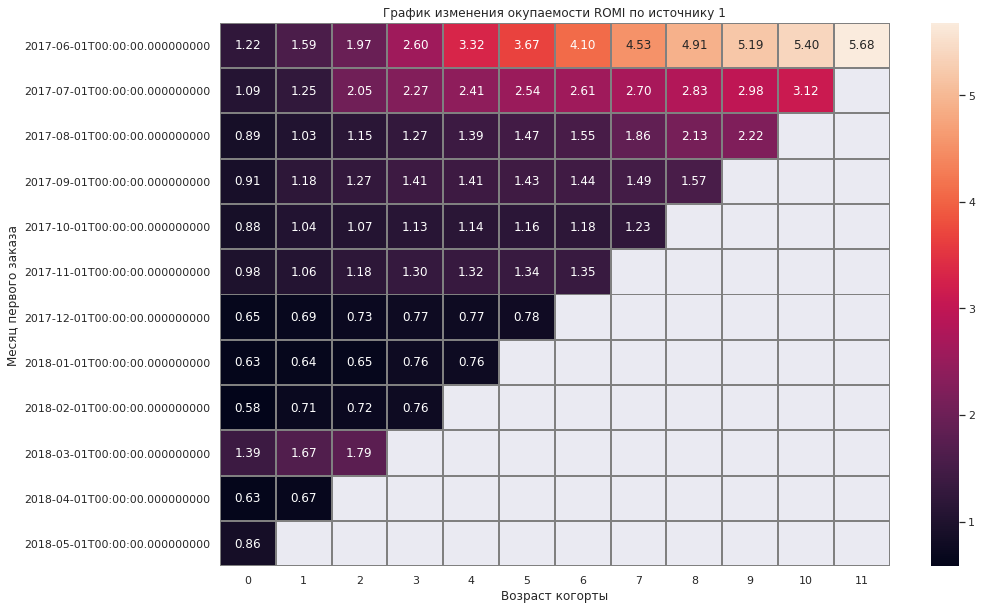

In [ ]:
print_romi_for_source(1)

- Когорты по 1 источнику окупаются в среднем на 1 месяц их жизни.
- С первого же месяца окупаются когорты 2017-06, 2017-07, 2018-03, так и не окупаются когорты 2017-12, 2018-01, 2018-02, 2018-04, 2018-05.
- Очень хороший LTV, наибольший по сравнению с остальными когортами.

Усредненный LTV для источника 2
12.47095859147666
---------------------------------------------------
Окупаемость ROMI по средней когорте для источника 2
age
0     0.549286
1     0.630051
2     0.777428
3     0.939189
4     1.085749
5     1.229496
6     1.029998
7     1.140317
8     1.215401
9     0.994079
10    1.290747
11    1.612957
dtype: float64


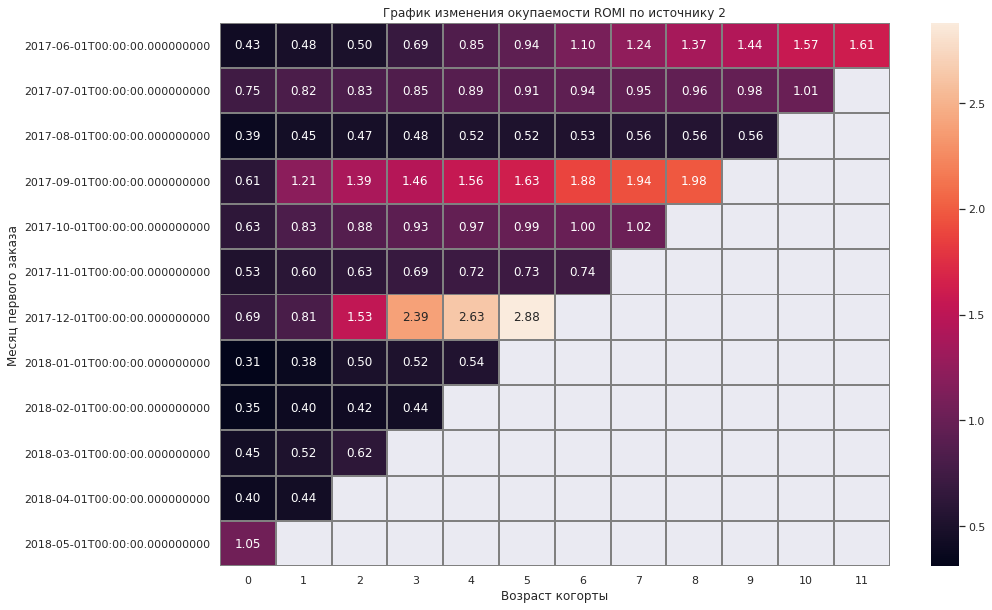

In [ ]:
print_romi_for_source(2)

- Когорты по 2 источнику окупаются в среднем на 4 месяц их жизни.
- С первого же месяца окупается когорта 2018-05
- Со второго месяца начинает окупаться когорта 2017-09
- Наибольшая окупаемость у когорты 2017-12
- 2- ой самый прибыльный источник среди остальных.

Усредненный LTV для источника 3
5.700647167639119
---------------------------------------------------
Окупаемость ROMI по средней когорте для источника 3
age
0     0.336151
1     0.357750
2     0.367152
3     0.379767
4     0.394988
5     0.413851
6     0.423732
7     0.442706
8     0.454574
9     0.429613
10    0.479128
11    0.470834
dtype: float64


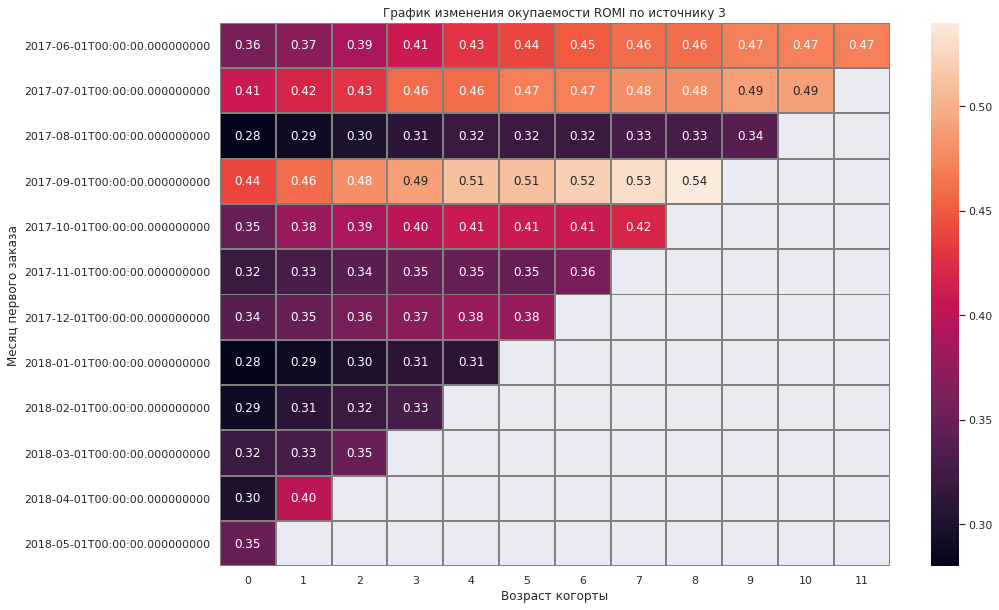

In [ ]:
print_romi_for_source(3)

- Ни одна из когорта по 3 источнику так и не окупилась.
- Прибыльность не очень высокая по сравнению с остальными когортами - 5.7 у.е.

Усредненный LTV для источника 4
6.7976122231360705
---------------------------------------------------
Окупаемость ROMI по средней когорте для источника 4
age
0     0.757409
1     0.776915
2     0.791630
3     0.814921
4     0.843845
5     0.900297
6     0.980375
7     0.900496
8     0.904477
9     0.952753
10    1.165144
11    1.420471
dtype: float64


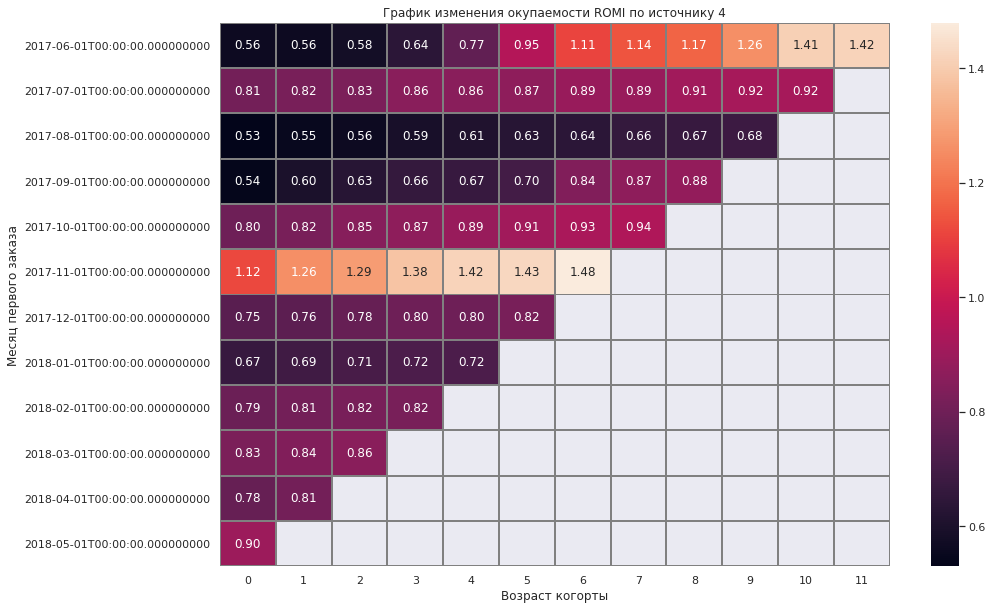

In [ ]:
print_romi_for_source(4)

- Когорты по 4 источнику окупаются в среднем на 10 месяц их жизни.
- С первого же месяца окупается когорта 2017-11
- С шестого месяца начинает окупаться когорта 2017-06
- Прибыльность есть, но не очень высока - 6.7 у.е.

Усредненный LTV для источника 5
8.833059592669388
---------------------------------------------------
Окупаемость ROMI по средней когорте для источника 5
age
0     0.664923
1     0.718179
2     0.779610
3     1.111582
4     1.231647
5     1.387731
6     1.549131
7     1.783598
8     2.016601
9     1.415622
10    1.306381
11    1.673333
dtype: float64


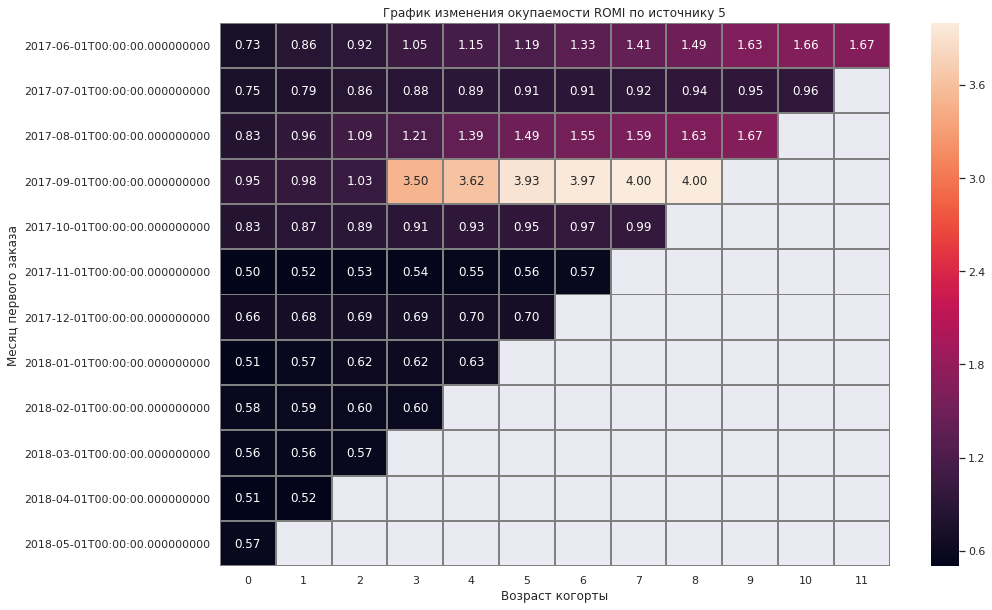

In [ ]:
print_romi_for_source(5)

- Когорты по 5 источнику окупаются в среднем на 3 месяц их жизни.
- Наибольшая окупаемость у когорты 2017-09
- Так же хорошо окупаются когорты 2017-06 (на 3 месяц жизни) и когорта 2017-08 (на второй месяц жизни)
- 3-ий самый прибыльный источник из всех - 8.7.у.е.

Усредненный LTV для источника 9
5.740234166002235
---------------------------------------------------
Окупаемость ROMI по средней когорте для источника 9
age
0     0.774013
1     0.847641
2     0.943664
3     1.041018
4     1.086613
5     1.216218
6     1.331051
7     1.455936
8     1.559885
9     1.428569
10    1.432871
dtype: float64


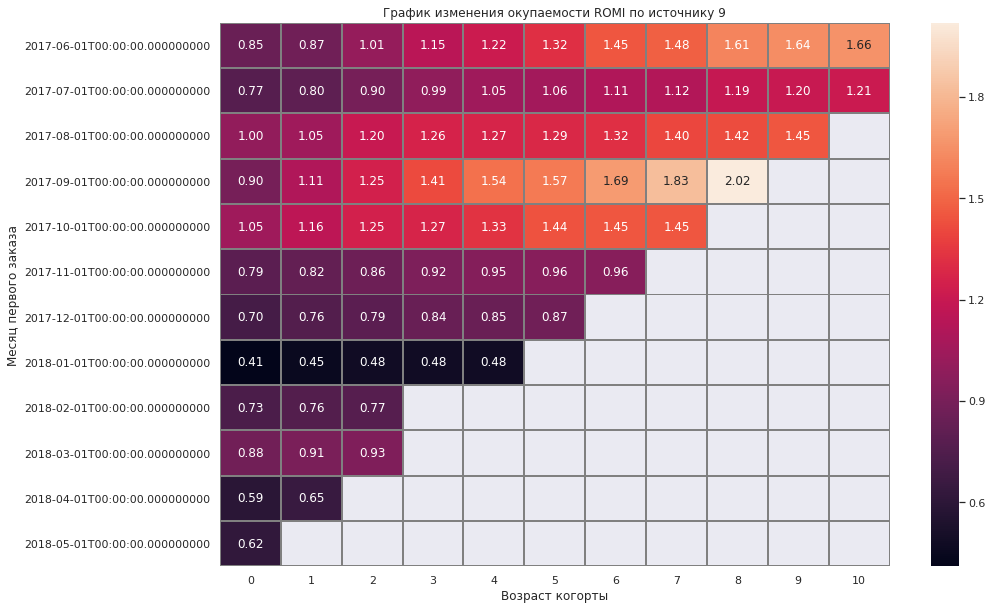

In [ ]:
print_romi_for_source(9)

- Когорты по 9 источнику окупаются в среднем на 3 месяц их жизни.
- В первый же месяц окупаются когорты 2017-08 и 2017-10
- Так же хорошо окупаются когорты 2017-06, 2017-07, 2017-09
- Когорты начиная с октября 2017 не окупаются
- Приыбльность не очень высокая, такая же как у источника 3, - 5.7 у.е.

Усредненный LTV для источника 10
3.7210842606258003
---------------------------------------------------
Окупаемость ROMI по средней когорте для источника 10
age
0    0.727377
1    0.708520
2    0.765743
3    0.685040
4    0.737312
5    0.754071
6    0.876620
7    0.773929
8    0.608024
9    0.899557
dtype: float64


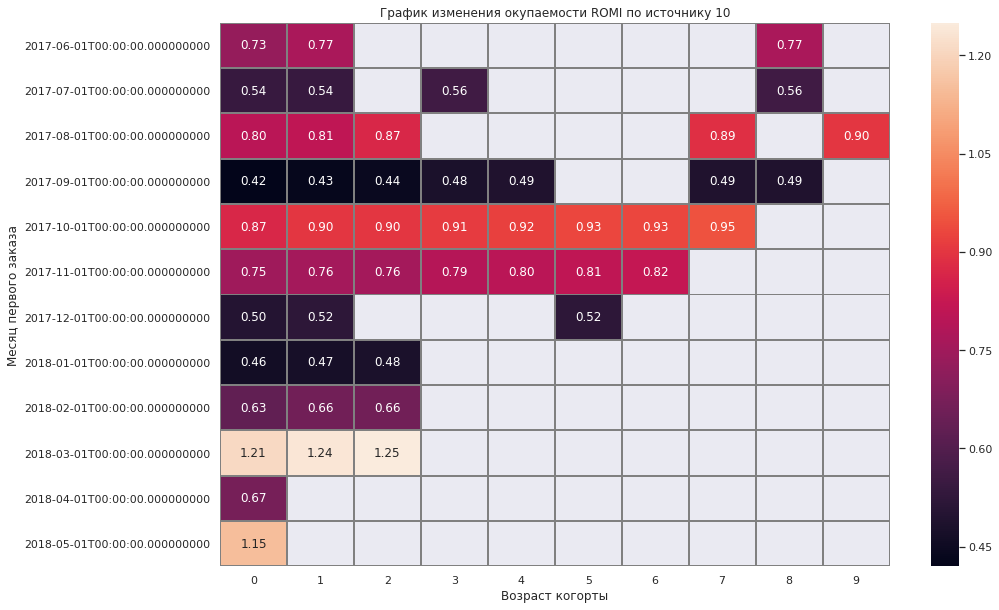

In [ ]:
print_romi_for_source(10)

- Средняя когорта по источнику 10 так и не окупается
- В разрезе источника 10 окупаются только когорты 2018-03 и 2018-05
- Самый низкоприбыльный источник из всех - 3.7.у.е.

## Выводы

#### Определите источники трафика, на которые маркетологам стоит делать упор. Объясните свой выбор: на какие метрики вы ориентируетесь и почему

- За все время на маркетинговые расходы было потрачено 329131.62 у.е.
- Наибольшее число маркетинговых трат 42.9% приходится на 3 источник, наименьшее на источники 1, 9 и 10.
- Исходя из анализа ROMI, самый окупаемый источник - 1. Хорошую окупаемость имеют также 2 и 5 источники. Самый дорогой источник - 3, но ни одна когорта по нему не окупается.
- Исходя из анализа усредненного LTV, самые прибыльные источники - 1, 2, 5. Самый низкоприбыльный - 10.

-  Таким образом моей рекомендацией было бы наиболее сконцентрироваться на источниках 1, 2 и 5. 

#### Опишите выводы, которые вы сделали после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции

- Количество уникальных пользователей достаточное, однако вовлеченность аудитории не очень высока, видимо пользователи редко пользуются сервисом.
- В среднем пользователи заходят на сайт один раз в день.
- Средняя продолжительность сессии пользователя на сайте равна 10 минутам, но чаще всего пользователи проводят на сайте не больше одной минуты.
- Чаще всего пользователи долго не думают над покупкой. Решение о покупке занимает у них 0 дней. Среднее время покупки 37 дней.
- Наибольшая активность пользователей сервиса приходится на конец года, на период перед новогодними праздниками, наименьшая активность - летом.
- Retention Rate активно убывает по когортам с течением времени. На первый месяц жизни когорты самый высокий RR у когорты 2017-09 - 8,5%, но в дальнейшем он начинает падать. Самая активная и постоянная на фоне остальных -первая когорта 2017-06.  Хорошие показатели RR на первые месяцы жизни также у когорт 2017-08, 2017-10, 2017-11, но с течением времени он также убывает.
- Проанализировав таблицу среднего количества покупок на одного пользователя видим, что показатель в 2 покупки достигается только у первой когорты 2017-06. По всем когортам число среднего количества покупок с течением времени увеличивается, но ненамного. Пользователи совершают повторные покупки, но не слишком часто.
- Средний чек покупки равен 5 у.е.
- Средний LTV или итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок, за 6 месяцев равен почти 8 у.е.
- Cредний CAC или стоимость привлечения клиента равен 9.01 у.е.
- Наибольшие значения CAC принимает в августе, январе и апреле, наименьшие в мае, октябре и декабре.

#### Подведите итоги когортного анализа. Определите самые перспективные для компании когорты клиентов

- Внимание надо особенно обратить на когорты 2017-09 и 2017-06. 2017-09 сильно выделяется по наибольшей выручке, в декабре по выручке она особенно вырывается вперед. Второе место по наибольшей выручке занимает когорта 2017-06.